In [405]:
import collections
import numpy as np
import pandas as pd
import re
import glob
import json

%matplotlib inline
import matplotlib.pyplot as plt

from argparse import Namespace

from torchtext.utils import download_from_url, extract_archive

Download the data from the [here](https://drive.google.com/uc?id=1k7GfVRqrHFK00ABkit0oGQo62fCakMSZ).   

Extract it to the folder called `.data`

In [406]:
args = Namespace(
    train_proportion=0.7,
    val_proportion=0.15,
    test_proportion=0.15,
    output_munged_csv=".data/faq_with_splits.csv",
    output_processed_csv_prefix=".data/faq_with_splits_",
    seed=1234,
    min_questions_per_category=3000
)

In [407]:
def find_files(path):
    return glob.glob(path)

def read_json(filename):
    with open(filename, encoding='utf-8', errors='ignore') as json_file:
        data = json.load(json_file)
    return data

In [408]:
frames = []

for file in find_files('.data/gyakori_*'):
    print("Reading file:", file)
    frames.append(pd.DataFrame(read_json(file)))
    
faq = pd.concat(frames).reset_index(drop=True)

Reading file: .data\gyakori_allatok_14000
Reading file: .data\gyakori_egeszseg
Reading file: .data\gyakori_egeszseg_20000
Reading file: .data\gyakori_szamitastechnika
Reading file: .data\gyakori_szorakozas_30000


In [409]:
faq.head()

,rovid_kerdes,hosszu_kerdes,valasz,kategoriak,keywords
0,Nagy terület őrzésére milyen kutyát javasolnátok?\nBővebben lent.,"Nagy terület őrzésére milyen kutyát javasolnátok? Bővebben lent. Régóta szerettünk volna kutyát tartani,de az igényeinknek nem tudjuk,hogy milyen kutya felelne meg,illetve,hogy mi milyen kutyának felelnénk meg.Ezért szeretném a segítségét kérni pár tapasztaltabb kutyásnak.Nem arról van szó,hogy nem tartottam még kutyát,hanem fajtákkal nem foglalkoztam túl sokat vagy épp nem én választottam ki azt.Párat én is ismerek,de nem annyira behatóan,hogy haza merjek hozni egyet mindenféle ismerettség nélkül.Adott egy nagy több hektáros terület,több féle-fajta-méretű állattal,így elsősorban egy állatokkal kompatibilis kutyára lenne szükségünk (lovak,egy szamár,szárnyasok,kecskék,pár bárány,struccok és nyulak).Vadász kutyákat ezért ki is lőttük,bár a következő pont miatt meg lehet,hogy pont ők felelnének meg.:Erdő és hegyek vannak mellettünk ahonnan vadállatok (főleg róka szokott) be tudnak jönni ezektől jó lenne,ha nem tartana.Nem kell,hogy öldököljön,csak azért ne hagyja őket bent garázdálkodni ha én nem veszem észre.Elég nekem az is,ha elüldözi őket.Van egy pár gyökér aki szintén rendszeresen bejár és lopja a tojásokat (nagy számban..),egy-egy csirke is szokott eltűnni,volt már,hogy sérüléseket hagytak az állatokon.Ezért mindenképpen olyat szeretnék aki nem retten meg,nem barátságos az idegenekkel.Nem kell,hogy harapjon,elég nekem az is,ha ugat,hogy észre vegyem és ki tudjak menni én is elzavarni őket.Szereltem fel ugyan kamerát több helyre,de az nem lát át egy kapusznin és napszemüvegen a bejárónk meg sajnos nem buta,hogy ezek nélkül jöjjön..:DAmiket tudnánk neki nyújtani:Mindenképpen többet szeretnénk beszerezni a kutyákból,de mindegyik a neki megfelelő ellátást ugyan úgy megkapná.Kint is lesz saját fűtött kutyaháza mindegyiknek ha esetleg úgy döntenének,hogy kint akarnak lenni egy-egy éjszaka.Kutya ajtónk lesz tehát bejárni be fognak tudni a házba.Elég nagy ahhoz,hogy akár nagy méretű kutyák is elférjenek velünk,tehát méretük mindegy.Szaporulatot nem szeretnénk így biztosan ivartalanítva lesz mindegyik.Otthoni területeken kívül tudnának jönni velünk a hegyekbe,az erdőbe,tóhoz is (a lovakat is gyakran le kell/szeretem mozgatni) gyakran sétálunk,futunk,mozgunk úgyhogy egy aktív,masszív kutya lenne jó.Egyedül semmiképpen nem maradnának az asszony és a gyerekekek mindig otthon vannak,és ugyan úgy lovakkal vagy gyalog,de mozognak tehát ha nem érek rá pár napig magán okok miatt akkor se maradnak egyedül vagy gondozatlanul az ebek sem.Van esetleg olyan kutyafajta ami nekünk megfelelne? Vagy ha menhelyen szétnézek és ugyan ezeket elmondom ott esélyes,hogy találok nekünk valókat?Előre is köszönöm :D","A komondor/kuvasz páros kimondottan ezekre a feladatokra lett kitenyésztve.Sajnos a kutya önmagában semmiféle védelmet nem nyújt, mert könnyű megmérgezni/lelőni. Egy megfigyelő rendszerrel, ""élőerős védelemmel"" együtt azonban komoly erőt képvisel.Az állatokkal való összeszoktatást mindenképpen egész kicsi korban el kell kezdeni.","[Állatok, Kutyák]","[kutya, őrkutya, aktív]"
1,Az álllatorvosunkat alig lehet elérni. Ez szerintetek\nnormális?,"Az álllatorvosunkat alig lehet elérni. Ez szerintetek normális? Magánrendelőről van szó, mobilszám van megadva 14:00-től 19:00-ig van rendelés, és most nem veszik fel a telefont. A múltkor rendelési időben hívtam őket, és az asszisztens vette fel, aki közölte, hogy most nincs a rendelőben és nem tud időpontot adni, de ha beért visszahív. Persze cseszett hívni, és mostmár kezdek dühös lenni. Aznapra amikor néha elérem őket már lehetetlen bekerülni, komolyabb esetnél cseszhetem is....",Keress másik orvost. Ennyi.,"[Állatok, Egyéb kérdések]","[állatorvos, időpont]"
2,Huskyval össze lehet szoktatni cicákat?,"Huskyval össze lehet szoktatni cicákat? A cica lenne először, utána a kutyus. Össze lehet őket szoktatni vagy esélytelen próbálkoznom? Valakinek sikerült már? Hogy?","Persze, hogy ös

In [410]:
faq.rename(columns = {
        "valasz": "answer",
        "kategoriak": "categories",
        "hosszu_kerdes": "long_question",
        "rovid_kerdes": "short_question"
    }, inplace = True)

In [411]:
faq['main_category'] = faq.apply(lambda row: row.categories[0], axis = 1)
faq['sub_category'] = faq.apply(lambda row: row.categories[1], axis = 1)

In [412]:
faq = faq.drop('keywords', axis = 1)
faq = faq.drop('categories', axis = 1)

In [413]:
faq.head()

,short_question,long_question,answer,main_category,sub_category
0,Nagy terület őrzésére milyen kutyát javasolnátok?\nBővebben lent.,"Nagy terület őrzésére milyen kutyát javasolnátok? Bővebben lent. Régóta szerettünk volna kutyát tartani,de az igényeinknek nem tudjuk,hogy milyen kutya felelne meg,illetve,hogy mi milyen kutyának felelnénk meg.Ezért szeretném a segítségét kérni pár tapasztaltabb kutyásnak.Nem arról van szó,hogy nem tartottam még kutyát,hanem fajtákkal nem foglalkoztam túl sokat vagy épp nem én választottam ki azt.Párat én is ismerek,de nem annyira behatóan,hogy haza merjek hozni egyet mindenféle ismerettség nélkül.Adott egy nagy több hektáros terület,több féle-fajta-méretű állattal,így elsősorban egy állatokkal kompatibilis kutyára lenne szükségünk (lovak,egy szamár,szárnyasok,kecskék,pár bárány,struccok és nyulak).Vadász kutyákat ezért ki is lőttük,bár a következő pont miatt meg lehet,hogy pont ők felelnének meg.:Erdő és hegyek vannak mellettünk ahonnan vadállatok (főleg róka szokott) be tudnak jönni ezektől jó lenne,ha nem tartana.Nem kell,hogy öldököljön,csak azért ne hagyja őket bent garázdálkodni ha én nem veszem észre.Elég nekem az is,ha elüldözi őket.Van egy pár gyökér aki szintén rendszeresen bejár és lopja a tojásokat (nagy számban..),egy-egy csirke is szokott eltűnni,volt már,hogy sérüléseket hagytak az állatokon.Ezért mindenképpen olyat szeretnék aki nem retten meg,nem barátságos az idegenekkel.Nem kell,hogy harapjon,elég nekem az is,ha ugat,hogy észre vegyem és ki tudjak menni én is elzavarni őket.Szereltem fel ugyan kamerát több helyre,de az nem lát át egy kapusznin és napszemüvegen a bejárónk meg sajnos nem buta,hogy ezek nélkül jöjjön..:DAmiket tudnánk neki nyújtani:Mindenképpen többet szeretnénk beszerezni a kutyákból,de mindegyik a neki megfelelő ellátást ugyan úgy megkapná.Kint is lesz saját fűtött kutyaháza mindegyiknek ha esetleg úgy döntenének,hogy kint akarnak lenni egy-egy éjszaka.Kutya ajtónk lesz tehát bejárni be fognak tudni a házba.Elég nagy ahhoz,hogy akár nagy méretű kutyák is elférjenek velünk,tehát méretük mindegy.Szaporulatot nem szeretnénk így biztosan ivartalanítva lesz mindegyik.Otthoni területeken kívül tudnának jönni velünk a hegyekbe,az erdőbe,tóhoz is (a lovakat is gyakran le kell/szeretem mozgatni) gyakran sétálunk,futunk,mozgunk úgyhogy egy aktív,masszív kutya lenne jó.Egyedül semmiképpen nem maradnának az asszony és a gyerekekek mindig otthon vannak,és ugyan úgy lovakkal vagy gyalog,de mozognak tehát ha nem érek rá pár napig magán okok miatt akkor se maradnak egyedül vagy gondozatlanul az ebek sem.Van esetleg olyan kutyafajta ami nekünk megfelelne? Vagy ha menhelyen szétnézek és ugyan ezeket elmondom ott esélyes,hogy találok nekünk valókat?Előre is köszönöm :D","A komondor/kuvasz páros kimondottan ezekre a feladatokra lett kitenyésztve.Sajnos a kutya önmagában semmiféle védelmet nem nyújt, mert könnyű megmérgezni/lelőni. Egy megfigyelő rendszerrel, ""élőerős védelemmel"" együtt azonban komoly erőt képvisel.Az állatokkal való összeszoktatást mindenképpen egész kicsi korban el kell kezdeni.",Állatok,Kutyák
1,Az álllatorvosunkat alig lehet elérni. Ez szerintetek\nnormális?,"Az álllatorvosunkat alig lehet elérni. Ez szerintetek normális? Magánrendelőről van szó, mobilszám van megadva 14:00-től 19:00-ig van rendelés, és most nem veszik fel a telefont. A múltkor rendelési időben hívtam őket, és az asszisztens vette fel, aki közölte, hogy most nincs a rendelőben és nem tud időpontot adni, de ha beért visszahív. Persze cseszett hívni, és mostmár kezdek dühös lenni. Aznapra amikor néha elérem őket már lehetetlen bekerülni, komolyabb esetnél cseszhetem is....",Keress másik orvost. Ennyi.,Állatok,Egyéb kérdések
2,Huskyval össze lehet szoktatni cicákat?,"Huskyval össze lehet szoktatni cicákat? A cica lenne először, utána a kutyus. Össze lehet őket szoktatni vagy esélytelen próbálkoznom? Valakinek sikerült már? Hogy?","Persze, hogy össze lehet.A kutyának az első pillanattól világosság

In [414]:
faq[faq.short_question.str.contains('\r')]

,short_question,long_question,answer,main_category,sub_category
153117,Tényleg ez történik a Star Wars-ban?\r\n\r\nSPOILER!!!!,Tényleg ez történik a Star Wars-ban?\r \r SPOILER!!!! A Star Wars legújabb filmében tényleg meg hal HanSolo?Rn meg nem láttam a filmet az egyik ismerősömtől hallottam,"Azert most mar jo ideje kint van a film, unnepek is voltak, szabadsagon is volt mindenki, aki akarta az mar szerintem megnezte.",Szórakozás,"Filmek, sorozatok"


In [415]:
def clear_escaped_characters(text):
    text = text.replace('\n', ' ')
    return text.replace('\r', ' ')

In [416]:
faq.long_question = faq.long_question.apply(lambda x: clear_escaped_characters(x))
faq.short_question = faq.short_question.apply(lambda x: clear_escaped_characters(x))
faq.answer = faq.answer.apply(lambda x: clear_escaped_characters(x))

In [417]:
faq = faq[~faq.long_question.str.contains('\[link\]') & ~faq.answer.str.contains('\[link\]')]

In [428]:
categories = set(faq.main_category)
print(categories)

{'Számítástechnika', 'Szórakozás', 'Egészség', 'Állatok'}


In [419]:
def number_of_questions_by_category():
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    fig.suptitle('Kérdések száma kategóriánként')

    grouped_faq = faq.groupby(faq.main_category)
    data_to_plot = grouped_faq.size().sort_values()

    data_to_plot.plot(kind='pie', ax=ax[0], autopct='%1.1f%%')
    data_to_plot.plot(kind='bar', ax=ax[1])

    y_axis_0 = ax[0].axes.get_yaxis()
    y_axis_0.set_visible(False)

    ax[1].set_xlabel("")
    ax[1].bar_label(ax[1].containers[0])
    
    for tick in ax[1].get_xticklabels():
        tick.set_rotation(0)

    plt.show()

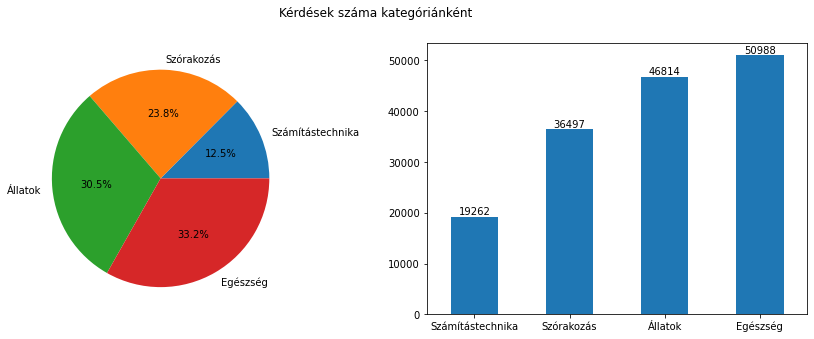

In [430]:
number_of_questions_by_category()

In [421]:
for category in categories:
    category_size = faq[faq.main_category == category].shape[0]
    if category_size < args.min_questions_per_category:
        faq = faq[faq.main_category != category]

In [422]:
def add_splits(df):
    by_main_category = collections.defaultdict(list)

    for _, row in df.iterrows():
        by_main_category[row.main_category].append(row.to_dict())
        
    final_list = []
    np.random.seed(args.seed)

    for _, item_list in sorted(by_main_category.items()):
        np.random.shuffle(item_list)
        n = len(item_list)
        n_train = int(args.train_proportion * n)
        n_val = int(args.val_proportion * n)
        n_test = int(args.test_proportion * n)

        for item in item_list[:n_train]:
            item['split'] = 'train'
        for item in item_list[n_train:n_train+n_val]:
            item['split'] = 'val'
        for item in item_list[n_train+n_val:]:
            item['split'] = 'test'  

        final_list.extend(item_list)
    return final_list

In [423]:
list_with_splits = add_splits(faq)

In [424]:
faq_with_splits = pd.DataFrame(list_with_splits)

In [425]:
faq_with_splits.head()

,short_question,long_question,answer,main_category,sub_category,split
0,Hogyan enyhítsek a stresszen?,"Hogyan enyhítsek a stresszen? Idén fogok felvételizni egy szakgimnáziumba. Ilyenkor mindenki stresszel, de én méginkább, mert egy olyan szakgimnáziumba szeretnék bejutni ahova már hat évvel ez előtt elhatároztam, hogy oda megyek. A hely nagyon kötődik a szívemhez. Például a nagyapám is oda járt és később azt hiszem taníott is. Elég népszerű, komoly iskola. Két osztályt indítanak évente és ötször-hatszoros a túljelentkezés. Azt mondják apszolút van esélyem bejutni, de nagyon stresszelek. (Egyébként ez egy rajzos suli..) Előkészítőre is járok már két éve, meg otthon is rajzolok. Sőt, az előkészítő tanárja is a szemembe mondta, higy én vagyok a legesélyesebb.(persze csak azokhoz viszonyított akiket lát az előkészítőkön) De nem bírok megnyugodni. Félek, hogy a felvételi napján a stressztől úgy le fogok blokkolni, hogy se rendesen kitölteni a teszteket, se egy normális és kész rajzot nem tudok majd elkészíteni. Nagyon igyekszem a jegyeimet is tartani a helyükön, nem állok rosszul, de nagyon félek. Főleg, hogy egy másik iskola(ahova megyek, ha nem vesznek fel és addig oda járok amég egy évvel később újra megpróbálok bekerülni a rajzosba) szóval a másik suliba szeretne menni a legtöbb jelenlegi osztálytársam. Aminek én nem örülök, mert nen szeretem őket. Vannak barátaim, de én nem illek oda és ha velük vagyol nem lehetek önmagam. De az iskolában ahova készülök. Ott már most szereztem pár legjobb barátot. Az az én helyem és be kell kerülnöm. A válaszaitokat előre is köszönöm és bocsi, ha helyesírási/fogalmazási hibát találtok!","Relaxációs technikák alkalmazása lenne jó: adott esetben egy egyalkalmas pszichológus terápia se lehetne annyira rossz. Kibeszéled vele azokat, amik benned vannak kétségek. Relaxáció, jóga, masszázs, sport... Ezek hiányoznak szerintem ahhoz, hogy nyugodtabb légy!",Egészség,Egyéb kérdések,train
1,Nektek hány napig tartott az első menstruációtok?,Nektek hány napig tartott az első menstruációtok?,Kb 3-4 napig.,Egészség,Nők egészsége,train
2,Mennyi idő alatt gyógyul be?,"Mennyi idő alatt gyógyul be? Ma volt délben egy fityma fék műtétem kb 15 percet vett igénybe csak egy kis lézeres műtét volt semmi szike , ez mennyi alatt gyógyul meg ,egyenlőre még meg se néztem (nem húztam hátra a fitymát) rakott a doki rá kötést hogyha esetleg vérezne így 2 óra elteltével sem vérzett , maszturbálás és nemi élet az mennyi idő múlva lehetséges ?",Nyalogasd mint a kutya :),Egészség,Férfiak egészsége,train
3,SOS! Ha a vesémmel van gond a laborba vért is vesznek vagy elég a vizelet minta?,"SOS! Ha a vesémmel van gond a laborba vért is vesznek vagy elég a vizelet minta? Holnap megyek orvoshoz beutalót kérni, de nem szeretnék vérvételt.. Szerintetek az is kell??Két napja görcsöl a vesém.. remélem elég a vizelet minta..","Kell. A vérvizsgálatnak is vannak olyan részei (fvs,süllyedés, kreatinin,karbamid szint),amik a vese funkciójára utalnak.",Egészség,Egészségügyi ellátások,train
4,"13 eves vagyok.60A a mellem, de az osztaly tarsamnak 65B es ezáltal ki is közösítenek hogy en nem vagyok olyan. ""menő"". Valami ötlet hátha nagyobb lesz?","13 eves vagyok.60A a mellem, de az osztaly tarsamnak 65B es ezáltal ki is közösítenek hogy en nem vagyok olyan. ""menő"". Valami ötlet hátha nagyobb lesz?","te jó isten ki nem sz*ja le hogy a másiknak mekkora a melle, főleg 13 évesen... mond meg nekik nyugodtan hogy szánalmas ha emiatt kiközösítenek valakit. És fog az még nőni ne aggódj, ők előbb kezdtek el érni, de attól még lehet hogy 5 év múlva az övék lesz egy mérettel kisebb.",Egészség,Nők egészsége,train


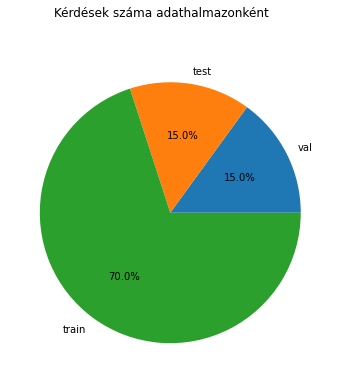

In [426]:
fig, ax = plt.subplots(1, figsize=(10, 6))

fig.suptitle('Kérdések száma adathalmazonként')
data_to_plot = faq_with_splits.groupby(faq_with_splits.split).size().sort_values()

data_to_plot.plot(kind='pie', ax=ax, autopct='%1.1f%%')

y_axis_0 = ax.axes.get_yaxis()
y_axis_0.set_visible(False)

plt.show()

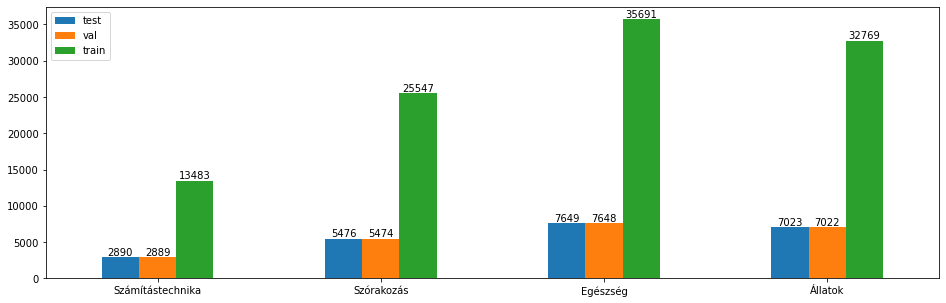

In [445]:
fig, ax = plt.subplots(1, figsize=(16, 5))

splits = list(set(faq_with_splits.split))

index = categories
questions_in = {}

for split in splits:
    questions_in[split] = []
    faq_split = faq_with_splits[faq_with_splits.split == split]
    
    for category in categories:
        questions_in[split].append(faq_split[faq_split.main_category == category].shape[0])

df = pd.DataFrame({split: questions_in[split] for split in splits}, index=index)        
df.head()

df.plot(kind='bar',ax=ax)

for tick in ax.get_xticklabels():
    tick.set_rotation(0)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])

plt.show()

In [151]:
from unidecode import unidecode

def unicode_to_ascii(data):
    return unidecode(re.sub(r"[,.;@#?!&$]+\ *", " ", data).lower(), errors='ignore')

ascii_faq = faq_with_splits.copy()

ascii_faq.long_question = ascii_faq.long_question.apply(lambda x: unicode_to_ascii(x))
ascii_faq.short_question = ascii_faq.short_question.apply(lambda x: unicode_to_ascii(x))
ascii_faq.answer = ascii_faq.answer.apply(lambda x: unicode_to_ascii(x))

In [152]:
ascii_faq.head()

,short_question,long_question,answer,main_category,sub_category,split
0,irnatok nekem valami biztatot,irnatok nekem valami biztatot miutan par napja...,oreg 14 eves korom ota dolgozok hogy amit a cs...,Egészség,Mentális egészség,train
1,vehetek be az antidepresszanssal egy idoben ny...,vehetek be az antidepresszanssal egy idoben ny...,2-esre ne hallgass segiteni fog az ad maskepp ...,Egészség,Mentális egészség,train
2,azt halottam tudogyulladassal nem nagyon kell ...,azt halottam tudogyulladassal nem nagyon kell ...,csak a hulyeseggel nem kell fekudni azt labon ...,Egészség,Betegségek,train
3,mit csinaljak ha szekal az osztalyom a miatt h...,mit csinaljak ha szekal az osztalyom a miatt h...,ignorald a kozossegek ilyenek kineznek valakit...,Egészség,"Immunrendszer, fertőzések",train
4,hirtelen nagyon eros lett a verzesem egyik per...,hirtelen nagyon eros lett a verzesem egyik per...,kedves kerdezo eloszor is nem tudom hany eves ...,Egészség,Nők egészsége,train


In [153]:
ascii_faq.split.value_counts()

train    117686
test      25223
val       25217
Name: split, dtype: int64

In [154]:
ascii_faq.to_csv(args.output_munged_csv, index=False)

### Lemmatization, stemming, stop-word filtering

In [157]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import HungarianStemmer
from nltk.corpus import stopwords

import nltk

import hu_core_ud_lg

In [158]:
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('hungarian'))

In [159]:
tokenizer = RegexpTokenizer(r'\w+')

stemmer = HungarianStemmer()

question = faq_with_splits.iloc[2]['long_question']

# Tokenization
tokenized_sentence = tokenizer.tokenize(question)

# Stopword filtering
filtered_sentence = [w for w in tokenized_sentence if not w in stop_words]

# Lemmatization
lemmatizer = hu_core_ud_lg.load()

lemmatizer.remove_pipe('parser')
lemmatizer.remove_pipe('ner')
lemmatizer.add_pipe(lemmatizer.create_pipe('sentencizer'))

doc = lemmatizer(" ".join(filtered_sentence))

In [160]:
print(f"Original question:\n{question}\n")

print("After tokenization:")
for w in tokenized_sentence:
    print(w, end=" ")

print("\n\nAfter stopword filtering:")
for w in filtered_sentence:
    print(w, end=" ")

print("\n\nAfter lemmatization:")
for w in doc:
    print(w.lemma_.lower(), end=" ")
    
print("\n\nAfter stemming:")
for w in tokenized_sentence:
    print(stemmer.stem(w), end=" ")

Original question:
Azt halottam tüdőgyulladással nem nagyon kell feküdni. Vese gyulladással pedig igen. Mivel sok vizelet távozik a másodikra gondoltam. Fő tünet bal oldalon középtájt fáj a hátam. Melyik lehet? Egész nap a fokozott vizeletürítésen kivűl bajom nincs, félig fekvő helyzetben pihenve 1 2 óra után megfájdúl.

After tokenization:
Azt halottam tüdőgyulladással nem nagyon kell feküdni Vese gyulladással pedig igen Mivel sok vizelet távozik a másodikra gondoltam Fő tünet bal oldalon középtájt fáj a hátam Melyik lehet Egész nap a fokozott vizeletürítésen kivűl bajom nincs félig fekvő helyzetben pihenve 1 2 óra után megfájdúl 

After stopword filtering:
Azt halottam tüdőgyulladással feküdni Vese gyulladással Mivel vizelet távozik másodikra gondoltam Fő tünet bal oldalon középtájt fáj hátam Melyik Egész nap fokozott vizeletürítésen kivűl bajom félig fekvő helyzetben pihenve 1 2 óra megfájdúl 

After lemmatization:
az halik tüdőgyulladás fekszik vese gyulladás mivel vizelet távozik 

In [161]:
import time

In [162]:
def tokenize_question(question):
    tokenized = tokenizer.tokenize(question)
    return " ".join(tokenized)

In [163]:
def lemmatize_question(question):
    doc = lemmatizer(question)
    lemmatized = [w.lemma_.lower() for w in doc]
    return " ".join(lemmatized)

In [164]:
def stem_question(question):
    stemmed = [stemmer.stem(w) for w in question.split()]
    return " ".join(stemmed)

In [165]:
def filter_question(question):
    tokenized_question = " ".join(tokenizer.tokenize(question))
    filtered = [w for w in tokenized_question.split() if not w in stop_words]

    return " ".join(filtered)

In [166]:
def create_dataset(questions, func, name):
    result = []

    start_time = int(time.time() * 1000)
       
    for idx, q in enumerate(questions):
        result.append(func(q))
    
    end_time = int(time.time() * 1000)
    print(f"Creating dataset called '{name}' took: {(end_time - start_time) / 1000.0} seconds")
    
    return result

In [167]:
def create_datasets(questions):
    result = {}
    
    result['tokenized'] = create_dataset(questions, tokenize_question, "tokenized")
    
    result['stemmed'] = create_dataset(questions, stem_question, "stemmed")
    result['lemmatized'] = create_dataset(questions, lemmatize_question, "lemmatized")
    
    result['filtered'] = create_dataset(questions, filter_question, "filtered")
    
    result['stemmed_filtered'] = create_dataset(result['filtered'], stem_question, "stemmed_filtered")
    result['lemmatized_filtered'] = create_dataset(result['filtered'], lemmatize_question, "lemmatized_filtered")
    
    return result

In [170]:
short_questions = faq_with_splits['short_question'].tolist()
long_questions = faq_with_splits['long_question'].tolist()

In [171]:
short_questions_datasets = create_datasets(short_questions)

Creating dataset called 'tokenized' took: 0.541 seconds
Creating dataset called 'stemmed' took: 25.767 seconds
Creating dataset called 'lemmatized' took: 270.458 seconds
Creating dataset called 'filtered' took: 0.868 seconds
Creating dataset called 'stemmed_filtered' took: 19.063 seconds
Creating dataset called 'lemmatized_filtered' took: 237.91 seconds


In [172]:
long_questions_datasets = create_datasets(long_questions)

Creating dataset called 'tokenized' took: 2.421 seconds
Creating dataset called 'stemmed' took: 137.853 seconds
Creating dataset called 'lemmatized' took: 573.057 seconds
Creating dataset called 'filtered' took: 3.976 seconds
Creating dataset called 'stemmed_filtered' took: 95.476 seconds
Creating dataset called 'lemmatized_filtered' took: 420.397 seconds


In [177]:
dataset_keys = list(short_questions_datasets.keys())

In [179]:
dataframes = {}
for key in dataset_keys:
    dataframe = faq_with_splits.copy()
    
    dataframe['short_question'] = short_questions_datasets[key]
    dataframe['long_question'] = long_questions_datasets[key]

    dataframes[key] = dataframe

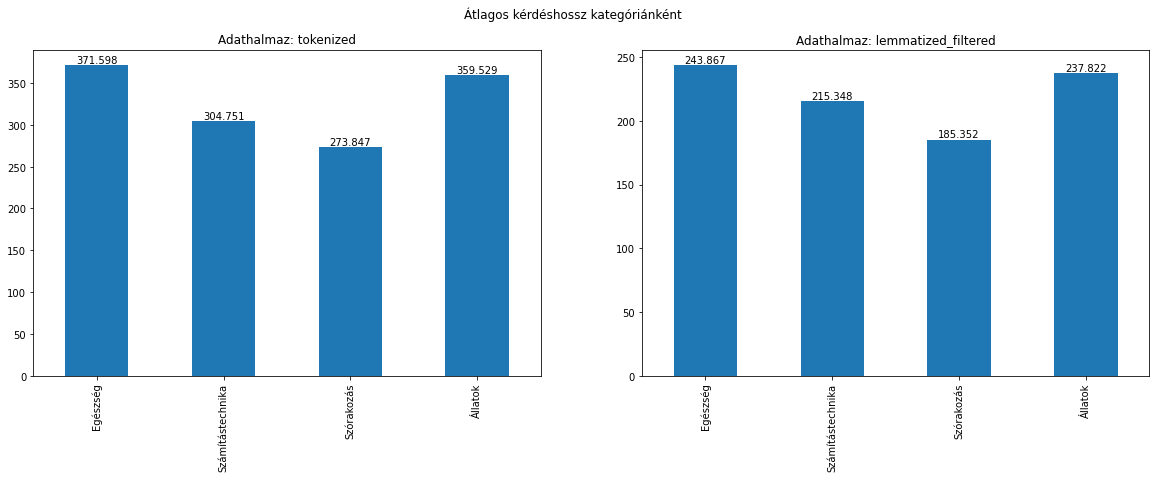

In [209]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle('Átlagos kérdéshossz kategóriánként')

datasets_to_display = ['tokenized', 'lemmatized_filtered']

for idx, dataset in enumerate(datasets_to_display):
    faq_to_display = dataframes[dataset]
    faq_to_display["long_question_len"] = faq_to_display.long_question.str.len()

    data_to_plot = faq_to_display.groupby(faq_to_display.main_category).long_question_len.mean()
    data_to_plot.plot(kind='bar', ax=ax[idx])
    
    ax[idx].set_title("Adathalmaz: " + dataset)
    ax[idx].set_xlabel("")
    ax[idx].bar_label(ax[idx].containers[0])

plt.show()

In [180]:
dataframes['filtered'].head()

,short_question,long_question,answer,main_category,sub_category,split
0,Írnátok biztatót,Írnátok biztatót Miután pár napja tűnt sikerül...,"Öreg.14 èves korom òta dolgozok,hogy amit a cs...",Egészség,Mentális egészség,train
1,Vehetek antidepresszánssal időben nyugtatót,Vehetek antidepresszánssal időben nyugtatót An...,"2-esre ne hallgass.Segíteni fog, az AD másképp...",Egészség,Mentális egészség,train
2,Azt halottam tüdőgyulladással feküdni Vese gyu...,Azt halottam tüdőgyulladással feküdni Vese gyu...,"Csak a hülyeséggel nem kell feküdni, azt lábon...",Egészség,Betegségek,train
3,Mit csináljak ha szekál osztályom miatt beteg ...,Mit csináljak ha szekál osztályom miatt beteg ...,"Ignoráld. A közösségek ilyenek, kinéznek valak...",Egészség,"Immunrendszer, fertőzések",train
4,Hirtelen erős vérzésem percről másikra ömleni ...,Hirtelen erős vérzésem percről másikra ömleni ...,Kedves kérdező!!Először is nem tudom hány éves...,Egészség,Nők egészsége,train


In [181]:
dataframes['stemmed'].head()

,short_question,long_question,answer,main_category,sub_category,split
0,írnát nek valam biztatót?,írnát nek valam biztatót? miut pár nap úgy tűn...,"Öreg.14 èves korom òta dolgozok,hogy amit a cs...",Egészség,Mentális egészség,train
1,vehet be az antidepresszáns egy idő nyugtatót?,vehet be az antidepresszáns egy idő nyugtatót?...,"2-esre ne hallgass.Segíteni fog, az AD másképp...",Egészség,Mentális egészség,train
2,az halott tüdőgyulladás nem nagy kell feküdni....,az halott tüdőgyulladás nem nagy kell feküdni....,"Csak a hülyeséggel nem kell feküdni, azt lábon...",Egészség,Betegségek,train
3,"mi csináljak, ha szekál az osztály a miatt, ho...","mi csináljak, ha szekál az osztály a miatt, ho...","Ignoráld. A közösségek ilyenek, kinéznek valak...",Egészség,"Immunrendszer, fertőzések",train
4,"hirtel nagy erős let a vérzésem, egy percről a...","hirtel nagy erős let a vérzésem, egy percről a...",Kedves kérdező!!Először is nem tudom hány éves...,Egészség,Nők egészsége,train


In [182]:
dataframes['lemmatized'].head()

,short_question,long_question,answer,main_category,sub_category,split
0,írnátok nek valami biztató ?,írnátok nek valami biztató ? miután pár nap úg...,"Öreg.14 èves korom òta dolgozok,hogy amit a cs...",Egészség,Mentális egészség,train
1,vehet be az antidepresszáns egy idő nyugtató ?,vehet be az antidepresszáns egy idő nyugtató ?...,"2-esre ne hallgass.Segíteni fog, az AD másképp...",Egészség,Mentális egészség,train
2,az halik tüdőgyulladás nem nagyon kell fekszik...,az halik tüdőgyulladás nem nagyon kell fekszik...,"Csak a hülyeséggel nem kell feküdni, azt lábon...",Egészség,Betegségek,train
3,"mi csinál , ha szekál az osztály a miatt , hog...","mi csinál , ha szekál az osztály a miatt , hog...","Ignoráld. A közösségek ilyenek, kinéznek valak...",Egészség,"Immunrendszer, fertőzések",train
4,"hirtelen nagyon erős lett a vérzésem , egyik p...","hirtelen nagyon erős lett a vérzésem , egyik p...",Kedves kérdező!!Először is nem tudom hány éves...,Egészség,Nők egészsége,train


In [183]:
dataframes['filtered'].head()

,short_question,long_question,answer,main_category,sub_category,split
0,Írnátok biztatót,Írnátok biztatót Miután pár napja tűnt sikerül...,"Öreg.14 èves korom òta dolgozok,hogy amit a cs...",Egészség,Mentális egészség,train
1,Vehetek antidepresszánssal időben nyugtatót,Vehetek antidepresszánssal időben nyugtatót An...,"2-esre ne hallgass.Segíteni fog, az AD másképp...",Egészség,Mentális egészség,train
2,Azt halottam tüdőgyulladással feküdni Vese gyu...,Azt halottam tüdőgyulladással feküdni Vese gyu...,"Csak a hülyeséggel nem kell feküdni, azt lábon...",Egészség,Betegségek,train
3,Mit csináljak ha szekál osztályom miatt beteg ...,Mit csináljak ha szekál osztályom miatt beteg ...,"Ignoráld. A közösségek ilyenek, kinéznek valak...",Egészség,"Immunrendszer, fertőzések",train
4,Hirtelen erős vérzésem percről másikra ömleni ...,Hirtelen erős vérzésem percről másikra ömleni ...,Kedves kérdező!!Először is nem tudom hány éves...,Egészség,Nők egészsége,train


In [184]:
dataframes['stemmed_filtered'].head()

,short_question,long_question,answer,main_category,sub_category,split
0,írnát biztató,írnát biztató miut pár nap tűnt siker kilábaln...,"Öreg.14 èves korom òta dolgozok,hogy amit a cs...",Egészség,Mentális egészség,train
1,vehet antidepresszáns idő nyugtató,vehet antidepresszáns idő nyugtató antidepress...,"2-esre ne hallgass.Segíteni fog, az AD másképp...",Egészség,Mentális egészség,train
2,az halott tüdőgyulladás feküdn ves gyulladás m...,az halott tüdőgyulladás feküdn ves gyulladás m...,"Csak a hülyeséggel nem kell feküdni, azt lábon...",Egészség,Betegségek,train
3,mi csinálj ha szekál osztály miat beteg hiányz,mi csinálj ha szekál osztály miat beteg hiányz...,"Ignoráld. A közösségek ilyenek, kinéznek valak...",Egészség,"Immunrendszer, fertőzések",train
4,hirtel erős vérzés percről más ömlen kezdet ré...,hirtel erős vérzés percről más ömlen kezdet ré...,Kedves kérdező!!Először is nem tudom hány éves...,Egészség,Nők egészsége,train


In [185]:
dataframes['lemmatized_filtered'].head()

,short_question,long_question,answer,main_category,sub_category,split
0,írnátok biztató,írnátok biztató miután pár nap tűnik sikerül k...,"Öreg.14 èves korom òta dolgozok,hogy amit a cs...",Egészség,Mentális egészség,train
1,vehet antidepresszáns idő nyugtató,vehet antidepresszáns idő nyugtató antidepress...,"2-esre ne hallgass.Segíteni fog, az AD másképp...",Egészség,Mentális egészség,train
2,az halik tüdőgyulladás fekszik vese gyulladás ...,az halik tüdőgyulladás fekszik vese gyulladás ...,"Csak a hülyeséggel nem kell feküdni, azt lábon...",Egészség,Betegségek,train
3,mi csinál ha szekál osztály miatt beteg hiányzik,mi csinál ha szekál osztály miatt beteg hiányz...,"Ignoráld. A közösségek ilyenek, kinéznek valak...",Egészség,"Immunrendszer, fertőzések",train
4,hirtelen erős vérzésem perc másikra ömlik kezd...,hirtelen erős vérzésem perc másikra ömlik kezd...,Kedves kérdező!!Először is nem tudom hány éves...,Egészség,Nők egészsége,train


In [186]:
dataframes['stemmed_filtered'].head()

,short_question,long_question,answer,main_category,sub_category,split
0,írnát biztató,írnát biztató miut pár nap tűnt siker kilábaln...,"Öreg.14 èves korom òta dolgozok,hogy amit a cs...",Egészség,Mentális egészség,train
1,vehet antidepresszáns idő nyugtató,vehet antidepresszáns idő nyugtató antidepress...,"2-esre ne hallgass.Segíteni fog, az AD másképp...",Egészség,Mentális egészség,train
2,az halott tüdőgyulladás feküdn ves gyulladás m...,az halott tüdőgyulladás feküdn ves gyulladás m...,"Csak a hülyeséggel nem kell feküdni, azt lábon...",Egészség,Betegségek,train
3,mi csinálj ha szekál osztály miat beteg hiányz,mi csinálj ha szekál osztály miat beteg hiányz...,"Ignoráld. A közösségek ilyenek, kinéznek valak...",Egészség,"Immunrendszer, fertőzések",train
4,hirtel erős vérzés percről más ömlen kezdet ré...,hirtel erős vérzés percről más ömlen kezdet ré...,Kedves kérdező!!Először is nem tudom hány éves...,Egészség,Nők egészsége,train


In [187]:
for dataframe_key in dataframes:
    filename = f"{args.output_processed_csv_prefix}{dataframe_key}.csv"
    print(f"Creating {filename}")
    dataframes[dataframe_key].to_csv(filename, index=False, encoding='utf-8', errors='ignore')

Creating .data/faq_with_splits_tokenized.csv
Creating .data/faq_with_splits_stemmed.csv
Creating .data/faq_with_splits_lemmatized.csv
Creating .data/faq_with_splits_filtered.csv
Creating .data/faq_with_splits_stemmed_filtered.csv
Creating .data/faq_with_splits_lemmatized_filtered.csv
